# Neural Network - MNIST

## Өгөгдөл бэлдэх

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import mnist
import helper
% matplotlib inline

train_datas, train_labels, test_datas, test_labels = mnist.load()


### Normalize data

In [2]:
def normalize(data):
    data_norm = data
    data_norm = [np.subtract(item, np.mean(item)) for item in data_norm]
    data_norm = [np.divide(item, np.std(item)) for item in data_norm]
    return np.array(data_norm)

In [3]:
train_datas_norm = normalize(train_datas)
test_datas_norm = normalize(test_datas)

### One Hot Encoding

In [4]:
train_y = np.array(pd.get_dummies(train_labels).as_matrix())
test_y = np.array(pd.get_dummies(test_labels).as_matrix())

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### NaN checker

In [5]:
def is_nan(x, msg):
    if type(x) is list or type(x) is np.ndarray:
        if type(x[0]) is list:
            for i, t in enumerate(x):
                if np.isnan(np.array(t, dtype=np.float64)).any():
                    print(x)
                    raise ValueError('NaN ' + str(i) + ': ' + msg)
            return None
        if type(x[0]) is np.ndarray:
            for i, t in enumerate(x):
                if np.isnan(t).any():
                    print(x)
                    raise ValueError('NaN ' + str(i) + ': ' + msg)
            return None
    try:
        if np.isnan(np.array(x, dtype=np.float64)).any():
            print(x)
            raise ValueError('NaN: ' + msg)
    except:
        print(x)
        raise ValueError('NaN: ' + msg)


## Тооцоолол хийхэд хэрэг болох функцууд

### Нарийвчлал тооцох

In [6]:
def accuracy(predicted, target):
    correct = 0
    for p, y in zip(predicted, target):
        if np.argmax(p) == np.argmax(y):
            correct += 1
    return correct/predicted.shape[0]*100

### RELU

#### Forward

\begin{equation*}
relu(y_i) = \begin{cases} 0, & y_i < 0 \\ y_i, & y_i\geq 0 \end{cases}
\end{equation*}

#### Backward

\begin{equation*}
\frac{\partial relu(y_i)}{\partial y_i} = \begin{cases} 0, & y_i < 0 \\ 1, & y_i\geq 0 \end{cases}
\end{equation*}

In [51]:
def relu(x, derivative=False):
    if derivative:
        is_nan(x, 'relu.backward - x')
        return 1 * (x >= 0)
    else:
        is_nan(x, 'relu.forward - x')
        return x * (x > 0)

### Softmax

\begin{equation*}
softmax(y_i) = \frac{e^{y_i}}{\sum_{j}e^{y_j}}
\end{equation*}


In [8]:
def softmax(x):
#     print(x)
    is_nan(x, 'softmax.forward - x')
    if np.ndim(x) == 1:
        x = x.T - np.max(x)
    else:
        x = x.T - np.max(x, axis=1)
    is_nan(x, 'softmax.forward - x-=max(x)')
    y = (np.exp(x) / np.sum(np.exp(x),axis=0)).T
    is_nan(y, 'softmax.forward - y')
    return y

### Negative Log Likelihood

- Y* - жинхэнэ ангилал
- Y - бодсон ангилал
- n - сургалтын өгөгдлийн тоо

#### Forward

\begin{equation*}
L = - \sum_{n} \sum_{i} Y_{ni}^* log(Y_{ni})
\end{equation*}

#### Backward

\begin{equation*}
\frac{\partial L}{\partial z_i} = Y_i - Y_{i}^*
\end{equation*}

In [9]:
def nll(P, Y, derivative=False):
    is_nan(P, 'nll - P')
    is_nan(Y, 'nll - Y')
    P = np.array(P)
    Y = np.array(Y)
    if derivative:
        return P - Y
    else:
#         print('[0 -- 10]')
#         print(P[0:10])
#         print('[100 -- 110]')
#         print(P[100:110])
        l = np.log(P) * Y
        is_nan(l, 'nll.forward - l')
        return -np.mean(l)

## Neural Network сургах

In [31]:
class NN:
    def __init__(self, classes, layer_neuron_counts):
        # Давхарга бүрийн нейроны тоо (жишээ нь [784, 64, 10])
        self.layer_neuron_counts = layer_neuron_counts
        # Ангилалууд
        self.classes = classes
        # Weight & Bias
        self.weights = []
        self.biases = []
        # Activation функц ашиглаагүй үеийн утгуудыг хадгалана
        self.layers = []
        # Activation функц ашиглаад гарсан утгуудыг хадгалана
        self.layers_activated = []
        # Loss утгуудыг хадгалах
        self.loss = []
        # Accuracy
        self.acc = []
        # SGD-н бодсон утгууд (dW, dB) болон моментум (vW, vB) хадгалах 
        self.cache = {
            'dW': 0,
            'dB': 0,
            'vW': 0,
            'vB': 0
        }

        # Weight болон bias-уудыг санамсаргүйгээр үүсгэх
        self.initialize_parameters()

    def initialize_parameters(self):
        for i in range(1, len(self.layer_neuron_counts)):
            prev_layer_size = self.layer_neuron_counts[i - 1]
            next_layer_size = self.layer_neuron_counts[i]
            self.weights.append(np.random.randn(prev_layer_size, next_layer_size) * 0.1)
            self.biases.append(np.random.randn(next_layer_size) * 0.1)

    def calculate_layer(self, i, activation='relu'):
        is_nan(self.layers_activated[i], 'calculate_layer - x')
        # Activation функц ашиглахаас өмнөх утга (H = WX + b)
        z = self.layers_activated[i] @ self.weights[i] + self.biases[i]
        # Activation функц ашигласны дараах утга (relu эсвэл softmax)
        a = None
        if activation == 'relu':
            a = relu(z)
        elif activation == 'softmax':
            a = softmax(z)
        return z, a

    def forward(self, x):
        self.layers = [x]
        self.layers_activated = [x]
        for i in range(len(self.layer_neuron_counts) - 1):
            # Activation функц ашиглахаас өмнөх утга (H = WX + b)
            z = None
            # Activation функц ашигласны дараах утга (relu(H) эсвэл softmax(H))
            a = None
            if i == len(self.layer_neuron_counts) - 2:
                z, a = self.calculate_layer(i, 'softmax')
            else:
                z, a = self.calculate_layer(i, 'relu')
            self.layers.append(z)
            self.layers_activated.append(a)
            is_nan(self.layers[len(self.layers) - 1],
                   'forward-' + str(i) + ' - self.layers[' + str(len(self.layers) - 1) + ']')
            is_nan(self.layers_activated[len(self.layers_activated) - 1],
                   'forward-' + str(i) + ' - self.layers_activated[' + str(len(self.layers) - 1) + ']')
        return self.layers_activated[-1]

    def backward(self, prediction, target):
        dW = []
        dB = []
        # ---
        d = [nll(prediction, target, derivative=True)]
        m = len(d)
        is_nan(d, 'sgd - d[0]')
        dW.append(np.transpose(self.layers_activated[1]) @ d[0])
        is_nan(dW, 'sgd - dW[0]')
        dB.append(np.sum(d[0], axis=0))
        is_nan(dB, 'sgd - db[0]')
        # ---
        d.append(np.multiply(d[0] @ np.transpose(self.weights[1]), relu(self.layers_activated[1], True)))
        is_nan(d, 'sgd - d[1]')
        dW.append(np.transpose(self.layers_activated[0]) @ d[1])
        is_nan(dW, 'sgd - dW[1]')
        dB.append(np.sum(d[1], axis=0))
        is_nan(dB, 'sgd - db[1]')
        dW.reverse()
        dB.reverse()
        return np.multiply(1/m, dW), np.multiply(1/m, dB)

    def train(self, train_x, train_y, epoch, batch_size, learning_rate, alpha=0):
        index = np.arange(train_x.shape[0])
        # Epoch
        for e in range(1, epoch + 1):
            print('Epoch: ' + str(e) + '/' + str(epoch))
            batch_count = round(len(train_y) / batch_size)
            np.random.shuffle(index)
            epoch_loss = []
            epoch_accuracy = []
            # Batch
            for b in range(0, batch_count):
                # Batch болгон хуваах
                l = b * batch_size
                r = l + batch_size
                batch_x = [train_x[i] for i in index[l:r]]
                batch_y = [train_y[i] for i in index[l:r]]
                # Batch-г боловсруулах
                dW, dB, loss, acc = self.batch_process(batch_x, batch_y)
                # Параметруудыг шинэчлэх
                self.update_parameters(dW, dB, learning_rate, alpha)
                # Loss, accuracy хадгалах
                epoch_loss.append(loss)
                epoch_accuracy.append(acc)

                helper.print_progress(b + 1, batch_count, loss=np.mean(epoch_loss), accuracy=np.mean(epoch_accuracy))
            self.loss.append(epoch_loss)
            self.acc.append(epoch_accuracy)
            print('')

    def batch_process(self, train_x, train_y):
        is_nan(self.weights, 'batch_process - self.weights')
        is_nan(self.biases, 'batch_process - self.biases')
        # Forward propagation
        predicted_y = self.forward(train_x)
        is_nan(predicted_y, 'batch_process - predicted_y')
        # Loss тооцох
        loss = nll(predicted_y, train_y)
        is_nan(loss, 'batch_process - loss')
        # Backward propagation
        dW, dB = self.backward(predicted_y, train_y)
        return dW, dB, loss, accuracy(predicted_y, train_y)

    def update_parameters(self, dW, dB, learning_rate, alpha):
#         [print(i) for i in dW]
        self.cache['vW'] = np.multiply(alpha, self.cache['vW']) + np.multiply((1 - alpha), dW)
        self.cache['vB'] = np.multiply(alpha, self.cache['vB']) + np.multiply((1 - alpha), dB)
        is_nan(self.cache['vW'], 'batch_process - self.cache - vW')
        is_nan(self.cache['vB'], 'batch_process - self.cache - vW')
        self.cache['dW'] = dW
        self.cache['dB'] = dB
        # Update weights
        self.weights = np.subtract(self.weights, np.multiply(learning_rate, self.cache['vW']))
        is_nan(self.weights, 'batch_process - self.weights - W')
        # Update biases
        self.biases = np.subtract(self.biases, np.multiply(learning_rate, self.cache['vB']))
        is_nan(self.biases, 'batch_process - self.biases - b')


In [37]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
nn = NN(classes, [len(train_datas_norm[0]), 300, len(classes)])
nn.train(train_datas_norm, train_y, 15, 150, 0.0004, 0.9)


Epoch: 1/15
[============================================================] 100.0% 400/400 loss: 0.04780 accuracy: 87.218%
Epoch: 2/15
[============================================================] 100.0% 400/400 loss: 0.02613 accuracy: 92.348%
Epoch: 3/15
[============================================================] 100.0% 400/400 loss: 0.02283 accuracy: 93.352%
Epoch: 4/15
[============================================================] 100.0% 400/400 loss: 0.02078 accuracy: 94.025%
Epoch: 5/15
[============================================================] 100.0% 400/400 loss: 0.01952 accuracy: 94.285%
Epoch: 6/15
[============================================================] 100.0% 400/400 loss: 0.01854 accuracy: 94.585%
Epoch: 7/15
[============================================================] 100.0% 400/400 loss: 0.01783 accuracy: 94.878%
Epoch: 8/15
[============================================================] 100.0% 400/400 loss: 0.01739 accuracy: 94.940%
Epoch: 9/15
[===========

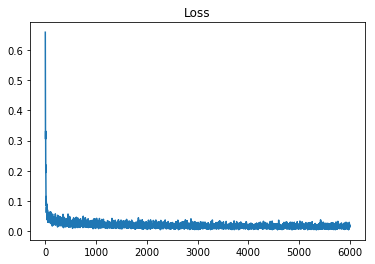

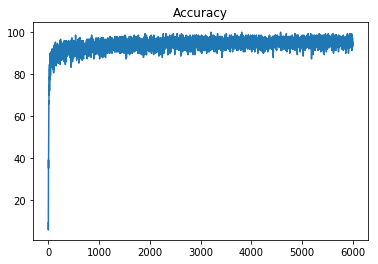

In [50]:
# loss = [np.mean(l) for l in nn.loss]
loss = np.array(nn.loss).ravel()
# accuracy = [np.mean(a) for a in nn.acc]
accuracy = np.array(nn.acc).ravel()
plt.title('Loss')
plt.plot(loss)
plt.show()
plt.title('Accuracy')
plt.plot(accuracy)
plt.show()

## Шалгах

In [40]:
predicted = nn.forward(test_datas_norm)
correct = 0
for i, (p, y) in enumerate(zip(predicted, test_labels)):
    if np.argmax(p) == y:
        correct += 1
accuracy = correct/predicted.shape[0]*100
print('Accuracy:', str(accuracy) + '%')

Accuracy: 94.26%


---

_уламжлал шалгах_

In [ ]:
# for i, d in enumerate(zip(training_images[0], training_images[1], training_images[2])):
#     print(i, d)
print(training_images[0][181])
print(training_images[1][181])
print(training_images[2][181])
print(nn.weights[0][181][14])

In [27]:
epsilon = 0.00001

data = train_datas_norm[0:3][:]
true_labels = train_y[0:3][:]
predicted_labels = nn.forward(data)
# print(np.multiply(true_labels, predicted_labels))
loss = nll(predicted_labels, true_labels)
dW, db = nn.backward(predicted_labels, true_labels)
dw = dW[0][181][14]

nn.weights[0][181][14] -= (epsilon/2)

predicted_labels = nn.forward(data)
# print(np.multiply(true_labels, predicted_labels))
loss1 = nll(predicted_labels, true_labels)
dW, db = nn.backward(predicted_labels, true_labels)
dw1 = dW[0][181][14]

nn.weights[0][181][14] += epsilon

predicted_labels = nn.forward(data)
# print(np.multiply(true_labels, predicted_labels))
loss2 = nll(predicted_labels, true_labels)
dW, db = nn.backward(predicted_labels, true_labels)
dw2 = dW[0][181][14]

print('loss-: ' + str(loss1))
print('loss : ' + str(loss))
print('loss+: ' + str(loss2))
print('dw-: ' + str(dw1))
print('dw : ' + str(dw))
print('dw+: ' + str(dw2))

print('\ndw-(l2-l1)/e: ', dw -  ((loss2-loss1)/epsilon))

loss-: 0.9532268026964797
loss : 0.9532268026964797
loss+: 0.9532268026964797
dw-: 0.4547497121078805
dw : 0.4547497121078805
dw+: 0.4547497121078805

dw-(l2-l1)/e:  0.4547497121078805
